In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from discretize_sepsis_actions import discretize_actions

In [108]:
# load data (from DH)
df = pd.read_csv("/Users/linyingzhang/Documents/2017_Fall/CS282/project/data_hw2/cleansed_data.csv")
df['state_cluster'] = df['state_cluster'].astype('int')
df['action_bin'] = df['action_bin'].astype('int')
# load trajectories (from DH)
trajectories = np.load("/Users/linyingzhang/Documents/2017_Fall/CS282/project/data_hw2/trajectories.npy")
# load transition_matrix 
transition_matrix = np.load("/Users/linyingzhang/Documents/2017_Fall/CS282/project/data_hw2/transition_matrix.npy")

In [109]:
transition_matrix.shape

(753, 25, 753)

In [112]:
trajectories.shape

(252204, 5)

In [96]:
df.head()

,CO2_mEqL,paCO2,Arterial_pH,sedation,SGPT,bloc,Weight_kg,charttime,rrt,SpO2,...,Chloride,Arterial_BE,state_cluster,input_total_tev,input_4hourly_tev,median_dose_vaso,max_dose_vaso,action_bin,died_in_hosp,mortality_90d
0,-1.393927,-0.850538,-0.367669,-0.651113,0.422769,1,-0.224117,7245052800,-0.266062,-0.207968,...,-0.308782,-1.100552,329,3500.0,2100.0,0.0,0.0,4,0,1
1,-1.393927,-0.850538,-0.367669,-0.651113,0.422769,2,-0.224117,7245067200,-0.266062,-1.359481,...,-0.308782,-1.100552,50,5499.0,1999.0,0.0,0.0,4,0,1
2,-0.940904,-0.740122,-0.293321,-0.651113,0.384762,3,-0.224117,7245081600,-0.266062,-0.160495,...,-0.017808,-0.924161,329,5604.0,105.0,0.0,0.0,2,0,1
3,-0.471104,-0.457906,-0.095059,-0.651113,0.380870,4,-0.224117,7245096000,-0.266062,-0.484716,...,0.011289,-0.453786,490,5664.0,60.0,0.0,0.0,2,0,1
4,-0.323452,-0.877933,0.777290,-0.651113,0.380870,5,-0.224117,7245110400,-0.266062,-0.546156,...,0.011289,-0.108845,532,5724.0,60.0,0.0,0.0,2,0,1


In [67]:
# # Directly taken from DH
# def make_mdp(trajectories, num_states, num_actions):
#     # TODO: fix this hard coding
#     num_terminal_states = 3
#     transition_matrix = np.zeros((num_states + num_terminal_states, num_actions, num_states + num_terminal_states))
#     reward_matrix = np.zeros((num_states + num_terminal_states, num_actions))
#     TRANSITION_PROB_UNVISITED_SAS = 0.0
#     REWARD_UNVISITED_SA = 0.0

#     # create dataframe for easy tallying
#     cols = ['s', 'a', 'r', 'new_s']
#     df = pd.DataFrame(trajectories[:,1:], columns=cols)
#     groups_sas = df.groupby(['s', 'a', 'new_s'])
#     groups_sa = df.groupby(['s', 'a'])
#     avg_reward_sa = groups_sa['r'].mean()
#     transition_count_sa = groups_sa.size()
#     transition_count_sas = groups_sas.size()
    
#     # TODO: vectorize this
#     # but everything is O(1) inside the loop so it's O(n^2m)
#     # TODO: consider mark transition to the imaginary terminal states
#     # to the prob of 1.0. this may be undesirable consequences
#     i = 0
#     print('this is a loop of length', num_states**2 * num_actions)
#     for s in range(num_states):
#         for a in range(num_actions):
#             # handle reward
#             if (s, a) in avg_reward_sa:
#                 reward_matrix[s, a] = avg_reward_sa[(s, a)]
#             else:
#                 reward_matrix[s, a] = REWARD_UNVISITED_SA
#             # handle transitions
#             if (s, a) in transition_count_sa:
#                 num_sa = transition_count_sa[(s, a)]
#                 for new_s in range(num_states):
#                     i+=1
#                     if i % 10000 == 0:
#                         print('i am doing fine, progress:', s, a, new_s)
#                     if (s, a, new_s) in transition_count_sas:
#                         num_sas = transition_count_sas[(s, a, new_s)]
#                         transition_matrix[s, a, new_s] = num_sas / num_sa
#                     else:
#                         transition_matrix[s, a, new_s] = TRANSITION_PROB_UNVISITED_SAS
#             else:
#                 transition_matrix[s, a, :] = TRANSITION_PROB_UNVISITED_SAS

#     return transition_matrix, reward_matrix

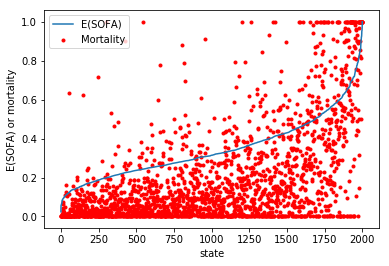

In [26]:
# # calculate the expected SOFA for each state
# def get_Expectation_SOFA(df, states_sequence, state_count):
#     state_E_SOFA = np.zeros((state_count, 1))
#     SOFA_score = df['SOFA']
#     SOFA_count = len(np.unique(SOFA_score))
#     state_SOFA_count_table = np.zeros((state_count, SOFA_count))
#     state_SOFA_matrix = np.zeros(state_SOFA_count_table.shape)

#     for state in range(state_count):
#         ind = np.where(states_sequence == state)[0]
#         state_sofa = SOFA_score[ind]
#         for sofa in state_sofa:
#             state_SOFA_count_table[state, sofa]+=1
#         state_SOFA_matrix[state, :] = state_SOFA_count_table[state, :]/sum(state_SOFA_count_table[state, :])
#         # compute expectation E(SOFA) for each state
#         state_E_SOFA[state,] = sum(state_SOFA_matrix[state, :]*range(SOFA_count))
#     return state_E_SOFA

# def get_state_mortality(df, states_sequence, state_count):    
#     outcome = df['died_in_hosp']
#     state_mortality = np.zeros((state_count, 1))
#     for state in range(state_count):
#         ind = np.where(states_sequence == state)[0]
#         state_death = outcome[ind]
#         state_mortality[state,] = float(sum(state_death))/len(state_death)
#     return state_mortality

# state_E_SOFA = get_Expectation_SOFA(df, states_sequence, state_count)
# state_mortality = get_state_mortality(df, states_sequence, state_count)
# # plot E(SOFA) and mortality for each state
# sorted_state_E_SOFA = np.sort(state_E_SOFA[:, 0])/max(state_E_SOFA[:, 0])
# ind_sorted = np.argsort(state_E_SOFA[:, 0])
# sorted_state_mortality = state_mortality[ind_sorted]
# plt.plot(sorted_state_E_SOFA, label = "E(SOFA)")
# plt.scatter(range(state_count), sorted_state_mortality, marker = ".", color = "red", label = "Mortality")
# plt.xlabel("state")
# plt.ylabel("E(SOFA) or mortality")
# plt.legend(loc = 'best')
# plt.show()

### Conclusion: Some sort of association of SOFA and mortality state-wise. 

In [32]:
def get_physician_policy_mode(states_sequence, actions_sequence, state_count, action_count):
    # S x A count table
    sa_count_table = np.zeros((state_count, action_count))
    physician_policy = np.zeros((state_count))
    for state in range(state_count):
        ind = np.where(states_sequence == state)[0]
        for action in range(action_count):
            sa_count_table[state, action] += sum(actions_sequence[ind] == action)
        physician_policy[state] = np.argmax(sa_count_table[state,:]) # when tie, smallest index returned
    return physician_policy

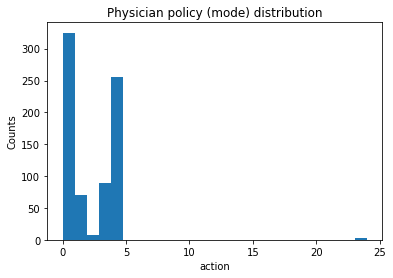

In [115]:
# plot physician's policy
states_sequence = df['state_cluster'].values
actions_sequence = df['action_bin'].values
state_count = 750
action_count = 25
physician_policy = get_physician_policy_mode(states_sequence, actions_sequence, state_count, action_count)
# plot physician's policy
plt.hist(physician_policy,bins=25)
plt.title("Physician policy (mode) distribution")
plt.xlabel("action")
plt.ylabel("Counts")
plt.show()
# Different distribution pattern than my action sequences?????

In [127]:
# columns that are binary:
def find_binary_columns(df):
    variables_to_use = []
    for i in range(df.shape[1]):
        if len(df.iloc[:,i].unique())==2:
            variables_to_use.append(i)
    #exclude last two columns: died_in_hosp and mortality_90d
    variables_to_use = variables_to_use[:-2]
    return variables_to_use
variables_to_use = find_binary_columns(df)
# display binary columns
df.iloc[:5,variables_to_use]

,sedation,rrt,mechvent,re_admission,gender
0,-0.651113,-0.266062,-0.891675,0,0
1,-0.651113,-0.266062,-0.891675,0,0
2,-0.651113,-0.266062,-0.891675,0,0
3,-0.651113,-0.266062,-0.891675,0,0
4,-0.651113,-0.266062,-0.891675,0,0


# IRL

In [138]:
# state basis function
def phi(centroid, state, variables_to_use):
    phi_st = centroid[state, variables_to_use]
    return phi_st

# sampling heuristic trajectories
def sampling_trajectories(transition_matrix, policy, m, state_count):
    absorption_states = [state_count, state_count+1, state_count+2]
    
    keys = range(m)
    sample_trajectories = dict.fromkeys(keys, None)
    
    for i in keys:
        sample_trajectories[i] = []
        #start from a random state
        state = int(np.random.choice(range(state_count)))
        sample_trajectories[i].append(state)
        while state not in absorption_states:
            action = int(policy[state])
            probs = transition_matrix[state,action,:]
            next_state = int(np.random.choice(np.arange(state_count+len(absorption_states)), p=probs))
            sample_trajectories[i].append(next_state)
            state = np.copy(next_state)
    return sample_trajectories
    
# function to calculate mu
def feature_expectation(sample_trajectories, gamma):
    mu = np.zeros((variable_count))
    
    # loop over all trajectories
    for i in range(m):
        trajectory = sample_trajectories[i]
        # loop over all states in that trajectory
        t = 0
        for state in trajectory:
            phi_st = phi(centroid, state, variables_to_use)
            mu += gamma**t*phi_st
            t+=1
    mu = 1/float(m)*mu    
    return mu

def reward(w, centroid, variables_to_use):
    R = w*centroid[:, variables_to_use]
    return R

In [141]:
gamma = 0.95
action_count = 25
state_count = 750

variables_to_use = find_binary_columns(df)
variable_count = len(variables_to_use)

# initialize w
w = np.zeros((variable_count))
# initialize policy pi
pi = np.zeros((state_count))
# make some random centroid matrix
centroid = np.ones((state_count, df.shape[1]))

R = reward(w, centroid, variables_to_use)

# sample trajectories
m=100
sample_trajectories = sampling_trajectories(transition_matrix, pi, m, state_count)
mu = feature_expectation(sample_trajectories, gamma)

ValueError: probabilities do not sum to 1

In [136]:
## PROBLEM ##: transition_matrix[state, action, :] NOT SUM TO 1 !!!
for state in range(state_count):
    for action in range(action_count):
        if sum(transition_matrix[state, action, :])!=1:
            if sum(transition_matrix[state, action, :])!=0:
                print (state, action)

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 6)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 9)
(1, 14)
(1, 17)
(1, 19)
(1, 24)
(2, 4)
(2, 14)
(2, 18)
(2, 19)
(2, 24)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 8)
(4, 14)
(4, 17)
(4, 19)
(4, 22)
(4, 23)
(4, 24)
(5, 1)
(5, 3)
(5, 14)
(5, 16)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 11)
(6, 14)
(6, 23)
(6, 24)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(9, 19)
(9, 23)
(10, 0)
(10, 1)
(10, 2)
(10, 3)
(10, 4)
(10, 24)
(11, 0)
(11, 1)
(11, 2)
(11, 3)
(12, 1)
(12, 3)
(12, 4)
(12, 13)
(12, 17)
(12, 18)
(12, 22)
(13, 0)
(13, 1)
(13, 2)
(13, 3)
(13, 4)
(13, 6)
(13, 7)
(13, 11)
(14, 0)
(14, 1)
(14, 2)
(14, 3)
(14, 4)
(14, 8)
(14, 13)
(14, 17)
(14, 19)
(15, 0)
(15, 1)
(15, 2)
(15, 3)
(15, 4)
(15, 6)
(15, 7)
(15, 8)
(15, 11)
(15, 14)
(15, 17)
(15, 18)
(15, 19)
(15, 21)
(15, 23)
(15, 24)
(16, 0)
(16, 3)
(16, 24)
(17, 0)
(17, 1)
(17, 2)
(17, 4)
(18, 0)
(18, 1)
(18, 2)
(18, 4)
(18, 10)
(19, 0)


(188, 12)
(188, 13)
(188, 14)
(188, 17)
(188, 24)
(189, 0)
(189, 1)
(189, 2)
(189, 3)
(189, 4)
(189, 7)
(189, 8)
(189, 9)
(189, 16)
(189, 18)
(189, 19)
(190, 4)
(190, 14)
(190, 19)
(190, 24)
(191, 0)
(191, 1)
(191, 2)
(191, 3)
(191, 4)
(191, 6)
(191, 13)
(191, 14)
(191, 17)
(191, 19)
(191, 24)
(192, 0)
(192, 1)
(192, 2)
(192, 3)
(193, 0)
(193, 1)
(194, 2)
(194, 7)
(194, 18)
(194, 24)
(195, 0)
(195, 1)
(195, 2)
(195, 3)
(195, 4)
(195, 8)
(195, 14)
(195, 18)
(195, 19)
(195, 23)
(195, 24)
(196, 0)
(196, 1)
(196, 2)
(196, 3)
(196, 6)
(197, 0)
(197, 1)
(197, 2)
(197, 3)
(197, 4)
(197, 7)
(197, 8)
(197, 13)
(197, 14)
(197, 18)
(197, 19)
(197, 22)
(197, 24)
(198, 0)
(198, 1)
(198, 2)
(198, 3)
(198, 4)
(198, 5)
(198, 7)
(198, 24)
(199, 0)
(199, 1)
(199, 2)
(199, 3)
(199, 4)
(199, 14)
(199, 19)
(199, 23)
(199, 24)
(200, 0)
(200, 1)
(200, 2)
(200, 3)
(200, 4)
(200, 9)
(200, 13)
(200, 14)
(200, 23)
(201, 0)
(201, 1)
(201, 2)
(201, 3)
(201, 4)
(201, 8)
(201, 24)
(202, 0)
(202, 1)
(202, 2)
(202, 3)

(398, 0)
(398, 1)
(398, 2)
(398, 3)
(398, 4)
(398, 7)
(398, 8)
(398, 9)
(398, 12)
(398, 14)
(398, 17)
(398, 18)
(398, 19)
(399, 0)
(399, 1)
(399, 2)
(399, 3)
(399, 4)
(399, 7)
(399, 9)
(399, 12)
(399, 14)
(399, 18)
(399, 21)
(399, 22)
(399, 24)
(400, 0)
(400, 1)
(400, 2)
(400, 3)
(400, 4)
(400, 7)
(401, 0)
(402, 0)
(402, 1)
(402, 2)
(402, 3)
(402, 4)
(402, 8)
(402, 12)
(402, 14)
(402, 17)
(402, 23)
(402, 24)
(403, 0)
(403, 1)
(403, 2)
(403, 3)
(403, 4)
(403, 8)
(403, 19)
(403, 23)
(404, 0)
(404, 1)
(404, 2)
(404, 3)
(404, 4)
(404, 6)
(404, 7)
(404, 13)
(404, 17)
(404, 21)
(404, 22)
(405, 0)
(405, 1)
(405, 2)
(405, 3)
(406, 0)
(406, 1)
(406, 2)
(406, 3)
(406, 4)
(406, 6)
(406, 8)
(406, 11)
(406, 12)
(406, 13)
(406, 14)
(406, 18)
(406, 19)
(406, 24)
(407, 0)
(407, 1)
(407, 2)
(407, 3)
(407, 4)
(407, 19)
(408, 0)
(408, 1)
(408, 2)
(408, 3)
(408, 7)
(409, 0)
(409, 1)
(409, 3)
(409, 4)
(409, 14)
(409, 17)
(409, 19)
(409, 24)
(410, 0)
(410, 1)
(410, 2)
(410, 3)
(410, 4)
(410, 7)
(410, 13)
(4

(514, 3)
(514, 4)
(514, 8)
(514, 19)
(514, 22)
(514, 24)
(515, 0)
(515, 1)
(515, 2)
(515, 3)
(515, 4)
(515, 7)
(515, 8)
(515, 12)
(515, 13)
(515, 14)
(515, 19)
(515, 23)
(515, 24)
(516, 0)
(516, 1)
(516, 2)
(516, 3)
(516, 4)
(516, 7)
(516, 12)
(517, 0)
(517, 1)
(517, 2)
(517, 3)
(517, 4)
(517, 6)
(517, 7)
(517, 11)
(517, 21)
(518, 0)
(518, 1)
(518, 2)
(518, 3)
(518, 7)
(518, 9)
(518, 12)
(518, 13)
(518, 14)
(518, 18)
(518, 23)
(518, 24)
(519, 0)
(519, 1)
(519, 2)
(519, 3)
(519, 4)
(519, 7)
(519, 10)
(519, 13)
(519, 22)
(520, 0)
(520, 1)
(520, 2)
(520, 3)
(520, 12)
(520, 24)
(521, 0)
(521, 1)
(521, 2)
(521, 3)
(521, 4)
(521, 7)
(521, 9)
(521, 12)
(521, 14)
(521, 24)
(522, 0)
(522, 1)
(522, 2)
(522, 3)
(523, 0)
(523, 1)
(523, 2)
(523, 3)
(523, 4)
(523, 7)
(523, 9)
(523, 11)
(523, 12)
(523, 24)
(524, 0)
(524, 1)
(524, 2)
(524, 3)
(524, 4)
(524, 7)
(524, 8)
(524, 9)
(524, 17)
(524, 23)
(524, 24)
(525, 0)
(525, 1)
(525, 2)
(525, 3)
(525, 4)
(525, 11)
(525, 13)
(525, 14)
(525, 18)
(525, 22)


(652, 0)
(652, 1)
(652, 2)
(652, 3)
(652, 4)
(652, 12)
(653, 0)
(653, 1)
(653, 2)
(653, 3)
(653, 4)
(653, 16)
(653, 17)
(653, 18)
(654, 0)
(654, 1)
(654, 2)
(654, 4)
(654, 9)
(654, 14)
(654, 17)
(654, 18)
(654, 19)
(654, 23)
(655, 0)
(655, 1)
(655, 2)
(655, 3)
(655, 4)
(655, 6)
(655, 12)
(655, 13)
(655, 14)
(655, 16)
(655, 18)
(656, 0)
(656, 1)
(656, 2)
(656, 3)
(656, 6)
(656, 7)
(656, 12)
(656, 17)
(656, 23)
(656, 24)
(657, 0)
(657, 1)
(657, 2)
(657, 3)
(657, 4)
(658, 0)
(658, 1)
(658, 2)
(658, 3)
(658, 4)
(658, 6)
(658, 8)
(658, 19)
(658, 24)
(659, 0)
(659, 1)
(659, 3)
(659, 4)
(659, 8)
(659, 9)
(659, 14)
(659, 17)
(659, 18)
(659, 19)
(659, 24)
(660, 0)
(660, 1)
(660, 2)
(660, 3)
(660, 4)
(660, 6)
(660, 16)
(661, 0)
(661, 1)
(661, 2)
(661, 3)
(661, 4)
(661, 17)
(661, 18)
(661, 19)
(661, 23)
(662, 0)
(662, 1)
(662, 2)
(662, 3)
(662, 4)
(662, 6)
(662, 7)
(663, 0)
(663, 1)
(663, 2)
(663, 3)
(663, 4)
(663, 6)
(663, 23)
(664, 0)
(664, 1)
(664, 2)
(664, 3)
(664, 4)
(664, 8)
(665, 0)
(665, 